<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [39]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Running on Apple GPU.")
else:
    print("MPS backend is not available. Running on CPU.")


MPS backend is available. Running on Apple GPU.


In [40]:
device = torch.device("mps")  # Use MPS for Apple Silicon
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("Tensor on MPS:", x)


Tensor on MPS: tensor([1., 2., 3.], device='mps:0')


In [41]:
# Parse the attributes.txt file
attribute_map = {}
with open('data/attributes.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(' ', 1)  # Split at the first space
        if len(parts) == 2:
            attr_id, attr_desc = parts
            attribute_map[int(attr_id)] = attr_desc

# Example: Print a few mappings
print("Attribute Map Sample:", list(attribute_map.items())[:10])


Attribute Map Sample: [(1, 'has_bill_shape::curved_(up_or_down)'), (2, 'has_bill_shape::dagger'), (3, 'has_bill_shape::hooked'), (4, 'has_bill_shape::needle'), (5, 'has_bill_shape::hooked_seabird'), (6, 'has_bill_shape::spatulate'), (7, 'has_bill_shape::all-purpose'), (8, 'has_bill_shape::cone'), (9, 'has_bill_shape::specialized'), (10, 'has_wing_color::blue')]


In [42]:
import numpy as np

# Load the .npy file
attributes_array = np.load('data/attributes.npy')

# Example: Print the shape and a sample
print("Attributes Array Shape:", attributes_array.shape)
print("Sample Attributes:", attributes_array[:5])


Attributes Array Shape: (200, 312)
Sample Attributes: [[0.0106384  0.0106384  0.00709227 ... 0.00918617 0.02526198 0.02066889]
 [0.         0.01133243 0.00944369 ... 0.00266542 0.02132333 0.05863916]
 [0.         0.         0.00742474 ... 0.         0.00885258 0.01770516]
 [0.         0.         0.00386105 ... 0.00683957 0.03647772 0.04331729]
 [0.         0.03508838 0.         ... 0.0027513  0.01513216 0.15819981]]


In [43]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from PIL import Image

# Step 1: Read and preprocess the CSV
data = pd.read_csv('data/train_images.csv')

# Prepend 'data' to paths if not already present
data['image_path'] = data['image_path'].apply(lambda x: f"data{x}" if not x.startswith("data") else x)

# Verify the first few paths
print(data['image_path'].head())

# Check if files exist
for path in data['image_path'].head():
    print(f"{path} exists: {os.path.exists(path)}")

# Step 2: Define a PyTorch Dataset 
# import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn

# Custom Dataset
class CombinedDataset(Dataset):
    def __init__(self, image_paths, attributes, labels, transform=None):
        self.image_paths = image_paths
        self.attributes = torch.tensor(attributes, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        attribute = self.attributes[idx]
        label = self.labels[idx]
        return image, attribute, label

    def __len__(self):
        return len(self.image_paths)

# Define transformations
from torchvision import transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# Create dataset and dataloader
image_paths = data['image_path'].values
labels = data['label'].values - 1  # Ensure labels are zero-indexed (0 to 199)
print(labels)

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming 'image_paths' and 'labels' from your dataset
data_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Add attributes to the DataFrame
attribute_df = pd.DataFrame(attributes_array, columns=[f"attr_{i}" for i in range(attributes_array.shape[1])])
data_df = pd.concat([data_df, attribute_df], axis=1)

# Example: Check combined data
print(data_df.head())

# One-hot encode categorical attributes
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_attributes = encoder.fit_transform(data_df.iloc[:, 2:].values)  # Assuming attributes start at column 2

# Example: Print the shape of the encoded attributes
print("Encoded Attributes Shape:", encoded_attributes.shape)
encoded_attributes = encoded_attributes.toarray() 

from sklearn.decomposition import PCA

# Use PCA to reduce dimensions of the one-hot encoded attributes
pca = PCA(n_components=256)  # Reduce to 128 features
reduced_attributes = pca.fit_transform(encoded_attributes)

print("Reduced Attributes Shape:", reduced_attributes.shape)  # Verify shape


# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# encoded_attributes = scaler.fit_transform(encoded_attributes)

dataset = CombinedDataset(image_paths, reduced_attributes, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

0    data/train_images/1.jpg
1    data/train_images/2.jpg
2    data/train_images/3.jpg
3    data/train_images/4.jpg
4    data/train_images/5.jpg
Name: image_path, dtype: object
data/train_images/1.jpg exists: True
data/train_images/2.jpg exists: True
data/train_images/3.jpg exists: True
data/train_images/4.jpg exists: True
data/train_images/5.jpg exists: True
[  0   0   0 ... 199 199 199]
                image_path  label    attr_0    attr_1    attr_2    attr_3  \
0  data/train_images/1.jpg      0  0.010638  0.010638  0.007092  0.003546   
1  data/train_images/2.jpg      0  0.000000  0.011332  0.009444  0.000000   
2  data/train_images/3.jpg      0  0.000000  0.000000  0.007425  0.000000   
3  data/train_images/4.jpg      0  0.000000  0.000000  0.003861  0.000000   
4  data/train_images/5.jpg      0  0.000000  0.035088  0.000000  0.000000   

     attr_4    attr_5    attr_6    attr_7  ...  attr_302  attr_303  attr_304  \
0  0.138299  0.065603  0.000000  0.005319  ...  0.000000  0.00543

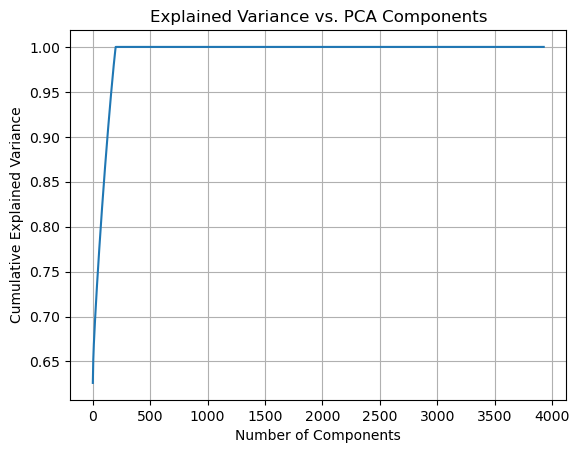

In [51]:
pca = PCA().fit(encoded_attributes)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

import matplotlib.pyplot as plt
plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. PCA Components')
plt.grid()
plt.show()


In [49]:
import torch.nn.functional as F
from torchvision.models import resnet18

class HybridModel(nn.Module):
    def __init__(self, num_image_features, num_attributes, num_classes):
        super(HybridModel, self).__init__()
        # CNN for images
        # self.cnn = nn.Sequential(
        #     nn.Conv2d(3, 32, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(32),  # Batch normalization
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Conv2d(32, 64, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(64),  # Batch normalization
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Flatten()
        # )
        self.cnn = resnet18(pretrained=True)
        
        num_image_features = self.cnn.fc.in_features

        self.cnn.fc = nn.Identity()  # Remove the last classification layer

        # Fully connected layers
        # self.fc_image = nn.Sequential(
        #     nn.Linear(64 * 37 * 37, num_image_features),
        #     nn.ReLU(),
        #     nn.Dropout(0.5)  # Dropout for regularization
        # )

        # Embedding layer for attributes
        # Attribute processing
        self.fc_attributes = nn.Sequential(
            nn.Linear(num_attributes, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

             # Fully connected layers
        self.fc_combined = nn.Sequential(
            nn.Linear(num_image_features + 256, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fc_output = nn.Linear(512, num_classes)

    def forward(self, image, attributes):
        # CNN forward
        image_features = self.cnn(image)
        # image_features = self.fc_image(image_features)
        # Process attributes
        attributes_features = torch.relu(self.fc_attributes(attributes))
        # Combine with attributes
        combined_features = torch.cat((image_features, attributes_features), dim=1)
        x = F.relu(self.fc_combined(combined_features))
        x = self.fc_output(x)
        return x

In [50]:
# Initialize model
num_image_features = 256
num_attributes = reduced_attributes.shape[1]
num_classes = len(set(labels))
model = HybridModel(num_image_features, num_attributes, num_classes).to(device)

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.01)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, attributes, labels in dataloader:
        images, attributes, labels = images.to(device), attributes.to(device), torch.tensor(labels).long().to(device)

        optimizer.zero_grad()
        outputs = model(images, attributes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/10, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

/var/folders/w9/03c_s4jn509125_l99795s6c0000gn/T/ipykernel_5700/3160424567.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, attributes, labels = images.to(device), attributes.to(device), torch.tensor(labels).long().to(device)


Epoch 1/10, Loss: 5.2969, Accuracy: 1.12%
Epoch 2/10, Loss: 5.0939, Accuracy: 3.59%
Epoch 3/10, Loss: 4.8372, Accuracy: 8.02%
Epoch 4/10, Loss: 4.5509, Accuracy: 11.67%
Epoch 5/10, Loss: 4.2043, Accuracy: 15.84%
Epoch 6/10, Loss: 3.8925, Accuracy: 19.36%
Epoch 7/10, Loss: 3.5943, Accuracy: 22.59%
Epoch 8/10, Loss: 3.2884, Accuracy: 27.89%
Epoch 9/10, Loss: 3.0020, Accuracy: 32.81%
Epoch 10/10, Loss: 2.7547, Accuracy: 37.77%


In [10]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 1: Define the transformations for the test data (same as for training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Step 2: Load the test dataset using ImageFolder
test_dir = 'data/test_images'  # Path to your test image directory

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffle for evaluation

# Step 3: Evaluate the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 0.45%
